In [0]:
# !pip install git+git://github.com/scikit-learn/scikit-learn.git
# from sklearn.preprocessing import CategoricalEncoder

### install category_encoders using pip install. I did this on google colab as I was getting error for using category encoder on my laptop

In [0]:
!pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
from google.colab import drive  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing the required libraries**

import warnings
warnings.filterwarnings("ignore")
import category_encoders as ce

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import os

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

import datetime
from math import sqrt
import re

import xgboost as xgb

**Load train and test dataset**

In [0]:
train = pd.read_csv('/content/drive/My Drive/dataset/ChartbustersParticipantsData/Data_Train.csv')
test = pd.read_csv('/content/drive/My Drive/dataset/ChartbustersParticipantsData/Data_Test.csv')

# train = pd.read_csv('Data_Train.csv')
# test = pd.read_csv('Data_Test.csv')

print("Number of data points in train data", train.shape)
print("Number of data points in test data", test.shape)

print("The attributes of data :", train.columns.values)

print('-'*50)
print(" Target column",set(train.columns.values)-set(test.columns.values))
print('-'*50)
train.head()


Number of data points in train data (78458, 11)
Number of data points in test data (19615, 10)
The attributes of data : ['Unique_ID' 'Name' 'Genre' 'Country' 'Song_Name' 'Timestamp' 'Views'
 'Comments' 'Likes' 'Popularity' 'Followers']
--------------------------------------------------
 Target column {'Views'}
--------------------------------------------------


,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,681116,Maxximize On Air,danceedm,AU,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,387253,GR6 EXPLODE,rbsoul,AU,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,1428029,Tritonal,danceedm,AU,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


**search for constant columns in the dataframe**

In [0]:
def const_col(df):
  const_col_lst = []
  for col in df.columns:
    if df['%s'%col].nunique()<2:
      const_col_lst.append(col)
  return const_col_lst

In [0]:
const_col(train)

['Country']

In [0]:
# train.info()

**Finding the unique values in the columns**

In [0]:
def unique_val_count(column):
    print('{:<15s}{:10d}'.format(column.name,column.nunique()))


 https://www.geeksforgeeks.org/python-pandas-series-str-replace-to-replace-text-in-a-series/<br>
 Python | Pandas Series.str.replace() to replace text in a series

 replace-comma-with-dot-pandas<br>
 https://stackoverflow.com/questions/40083266/replace-comma-with-dot-pandas

 replaceing multple signs<br>
 https://stackoverflow.com/questions/38516481/trying-to-remove-commas-and-dollars-signs-with-pandas-in-python


**Data cleaning: Columns such as 'Like' and 'Popularity' have character notation for representing the numbers, so we replace them with required values**

In [0]:
train_updated=train.copy()
train_updated['Likes']=train_updated['Likes'].replace({',':'','K':'000'},regex=True)
train_updated['Popularity']=train_updated['Popularity'].replace({',':'','K':'000'},regex=True)
train_updated['Likes']=train_updated['Likes'].str.replace(r'[^\d]', '')

train_updated[['Likes','Popularity']] = train_updated[['Likes','Popularity']].apply(pd.to_numeric)


In [0]:
test_updated=test.copy()
test_updated['Likes']=test_updated['Likes'].str.replace(r'[^\d]', '')
test_updated['Likes']=test_updated['Likes'].replace({',':'','K':'000'},regex=True)
test_updated['Popularity']=test_updated['Popularity'].replace({',':'','K':'000'},regex=True)
test_updated[['Likes','Popularity']] = test_updated[['Likes','Popularity']].apply(pd.to_numeric)


In [0]:
train_updated.drop(columns="Country",inplace=True)
test_updated.drop('Country',axis=1,inplace=True)


In [0]:
# train_updated.drop(columns="Song_Name",inplace=True)
# test_updated.drop('Song_Name',axis=1,inplace=True)

# train_updated.drop('Unique_ID',axis=1,inplace=True)
# test_updated.drop('Unique_ID',axis=1,inplace=True)



Cannot replace special characters in a Python pandas dataframe<br>
https://stackoverflow.com/questions/50846719/cannot-replace-special-characters-in-a-python-pandas-dataframe


**Using the Timestamp to create extra features**

In [0]:
train_updated['Timestamp'] = train_updated['Timestamp'].astype('datetime64[ns]')
train_updated["day"]     = train_updated['Timestamp'].dt.day # extracting day
train_updated["weekday"] = train_updated['Timestamp'].dt.weekday #extracting week day
train_updated["month"]   = train_updated['Timestamp'].dt.month 
train_updated["year"]    = train_updated['Timestamp'].dt.year 
train_updated["hour"]    = train_updated['Timestamp'].dt.hour
train_updated["minute"]    = train_updated['Timestamp'].dt.minute


In [0]:
test_updated['Timestamp'] = test_updated['Timestamp'].astype('datetime64[ns]')
test_updated["day"]       = test_updated['Timestamp'].dt.day # extracting day
test_updated["weekday"]   = test_updated['Timestamp'].dt.weekday #extracting week day
test_updated["month"]     = test_updated['Timestamp'].dt.month 
test_updated["year"]      = test_updated['Timestamp'].dt.year 
test_updated["hour"]      = test_updated['Timestamp'].dt.hour
test_updated["minute"]    = test_updated['Timestamp'].dt.minute


In [0]:
train_updated["weekend"] = train_updated["weekday"].apply(lambda x: 0 if x<5 else 1)
test_updated["weekend"]   = test_updated["weekday"].apply(lambda x:0  if x<5 else 1)

In [0]:
time="2014-08-13 12:21:34.000000"
datetimeFormat = '%Y-%m-%d %H:%M:%S.%f'
d = datetime.datetime.strptime(time, datetimeFormat)
compare_value = math.ceil(d.hour+(d.minute/60))
compare_value

13

In [0]:
def cond1(time):
  # if((hr>=0 & mini>=0) & (hr<6 & mini>=0) | (hr==6 & mini==0)):
  #   return 1
  # elif((hr>=6 & mini>0) & (hr<12 & mini>=0) | (hr==12 & mini==0)):
  #   return 2
  # elif((hr>=12 & mini>0) & (hr<18 & mini>=0) | (hr==18 & mini==0)):
  #   return 3
  # else:
  #   return 4
  datetimeFormat = '%Y-%m-%d %H:%M:%S.%f'
  d = datetime.datetime.strptime(time, datetimeFormat)
  compare_value = math.ceil(d.hour+(d.minute/60))
  if (compare_value>0 & compare_value<=6):
    return 1
  elif (compare_value>6 & compare_value<=12):
    return 2
  elif compare_value>12 & compare_value<=18:
    return 3
  else :
    return 4
  # print(compare_value)

https://thispointer.com/pandas-apply-a-function-to-single-or-selected-columns-or-rows-in-dataframe/
https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

### Pandas: Apply a function to single or selected columns or rows in Dataframe

1. df['col_3'] = df[['col_1','col_2']].apply(lambda x: f(*x), axis=1)
2. df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)


In [1]:
# train_updated['Timestamp'][:5].apply(lambda x: cond1(x))

In [0]:
train_updated["time_period"] = train_updated['Timestamp'].apply(lambda x: cond1(x))

In [0]:
# train_updated["time_period"] = train_updated["weekday"].apply(lambda x: 1 if x<5 else 0)
# test_updated["time_period"]   = test_updated["weekday"].apply(lambda x: 1 if x<5 else 0)

In [0]:
# test_updated.drop(columns="Timestamp",inplace=True)
# train_updated.drop(columns="Timestamp",inplace=True)

**Basic stats about the train data**

In [0]:
train_updated.describe()

,Unique_ID,Views,Comments,Likes,Popularity,Followers,day,weekday,month,year,hour,minute,weekend
count,7.845800e+04,7.845800e+04,78458.000000,78458.000000,78458.000000,7.845800e+04,78458.000000,78458.000000,78458.000000,78458.000000,78458.000000,78458.000000,78458.000000
mean,7.451701e+05,5.469686e+05,115.270973,30830.841915,592.799855,4.787663e+05,15.513026,2.579609,6.523962,2015.931951,12.314984,24.993576,0.866374
std,4.805507e+05,3.883085e+06,724.614868,108784.348397,3459.825521,1.168120e+06,8.811091,1.785213,3.622101,2.770140,7.199088,19.304455,0.340252
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,1.000000,1973.000000,0.000000,0.000000,0.000000
25%,3.149512e+05,6.216500e+03,1.000000,129.000000,12.000000,1.770000e+04,8.000000,1.000000,3.000000,2015.000000,7.000000,6.000000,1.000000
50%,6.618655e+05,2.538650e+04,12.000000,664.000000,80.550000,8.768200e+04,16.000000,3.000000,7.000000,2017.000000,14.000000,24.000000,1.000000
75%,1.176618e+06,1.201342e+05,61.000000,2843.000000,369.000000,3.936550e+05,23.000000,4.000000,10.000000,2018.000000,18.000000,42.000000,1.000000
max,1.570012e+06,1.994050e+08,104082.000000,999000.000000,324000.000000,9.789123e+06,31.000000,6.000000,12.000000,2019.000000,23.000000,59.000000,1.000000


**comments,likes and popularity have large values above 75% of data**


In [0]:
# https://pythonprogramming.net/bar-chart-histogram-matplotlib-tutorial/
def histo(col,df):
  bin_size=[]
  bin_modifier=0.25
  bin_val=round((df['%s'%col].max()-df['%s'%col].mean())/df['%s'%col].mean())/bin_modifier
  bin_size.append(bin_val)
  steps=math.ceil(df['%s'%col].max()/bin_size[0])
  for i in range(1,steps+2):
    bin_size.append(bin_val*(i+1))
  plt.figure(figsize=(5,5))
  plt.hist(df['%s'%col],bins=bin_size, histtype='bar', rwidth=0.8)

  plt.xlabel('%s'%col)
  # plt.ylabel('y')
  plt.show()
  # print(steps,"\n",bin_val,"\n",df['%s'%col].max())

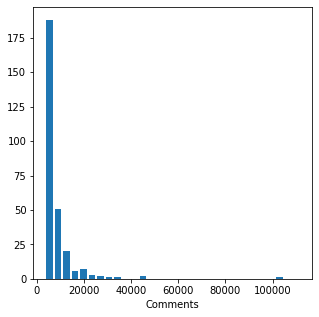

In [0]:
histo('Comments',train_updated)

In [0]:
value=0.3
def yellow(val):
  color = 'yellow' if val > value else 'orange' if val<-value else ''
  return 'background-color:' + color 

def bold(val):    
  bold = 'bold' if val > value else 'orange' if val<-value else ''
  return 'font-weight:'+ bold

### bold all the results from pyhton based on condition
  https://stackoverflow.com/questions/58344309/pandas-conditionally-format-field-in-bold

In [0]:
train_updated.corr().style.\
  applymap(yellow).\
  applymap(bold)

,Unique_ID,Views,Comments,Likes,Popularity,Followers,day,weekday,month,year,hour,minute,weekend
Unique_ID,1,-0.00895631,-0.00722275,-0.0120304,-0.00105945,-0.026958,-0.0198911,0.00495059,-0.0473047,-0.0530635,0.0151922,0.0071855,0.00279496
Views,-0.00895631,1,0.679104,0.370392,0.55742,0.103603,0.010813,0.0146455,0.00260111,-0.00904297,-0.0322909,-0.0244495,0.00295195
Comments,-0.00722275,0.679104,1,0.261699,0.441939,0.0850337,0.00647142,-0.00184435,0.00409791,-0.00745506,0.00254773,-0.00525643,0.00239421
Likes,-0.0120304,0.370392,0.261699,1,0.252081,0.140555,0.0170484,0.0216416,0.00785785,-0.014008,-0.0287089,-0.0214739,0.0140221
Popularity,-0.00105945,0.55742,0.441939,0.252081,1,0.0832206,0.00702439,-0.00811837,0.00585906,-0.0244017,0.00764986,0.00309687,0.0124276
Followers,-0.026958,0.103603,0.0850337,0.140555,0.0832206,1,0.0140291,-0.0319332,-0.00349011,-0.180333,-0.120028,-0.132121,0.0760205
day,-0.0198911,0.010813,0.00647142,0.0170484,0.00702439,0.0140291,1,0.00471366,0.0539908,0.0997658,0.0391397,0.0256535,0.00979777
weekday,0.00495059,0.0146455,-0.00184435,0.0216416,-0.00811837,-0.0319332,0.00471366,1,0.0107365,0.0967893,-0.0826263,-0.0349792,-0.631842
month,-0.0473047,0.00260111,0.00409791,0.00785785,0.00585906,-0.00349011,0.0539908,0.0107365,1,-0.00407203,0.0379256,0.030357,0.00227749
year,-0.0530635,-0.00904297,-0.00745506,-0.014008,-0.0244017,-0.180333,0.0997658,0.0967893,-0.00407203,1,0.180095,0.121408,-0.0258749


In [0]:
category_data=train_updated.select_dtypes(['object']).copy()

category_data.head()

,Name,Genre,Song_Name
0,Hardstyle,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...
1,Dj Aladdin,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix
2,Maxximize On Air,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...
3,GR6 EXPLODE,rbsoul,MC Yago - Tenho Compromisso (DJ R7)
4,Tritonal,danceedm,Escape (feat. Steph Jones)


In [0]:
category_col=category_data.columns
numeric=list(set(train_updated.columns)-set(category_col))
print("category",category_col)
print('-'*50)
print("numeric",numeric)

#### count of unique categories

for i in category_col:
    unique_val_count(train[i])

category Index(['Name', 'Genre', 'Country', 'Song_Name', 'Timestamp'], dtype='object')
--------------------------------------------------
numeric ['Likes', 'Popularity', 'Comments', 'Followers', 'Unique_ID', 'Views']
Name                 1209
Genre                  21
Country                 1
Song_Name           78457
Timestamp           68187



**1. We can see test name has some more values so we combine test and train and encode but for genre we can encode using mean targeting**

**2. As country is const so we drop**


In [0]:
def unique_val_count(column):
    print('{:<15s}{:10d}'.format(column.name,column.nunique()))


**Density plot of View column**

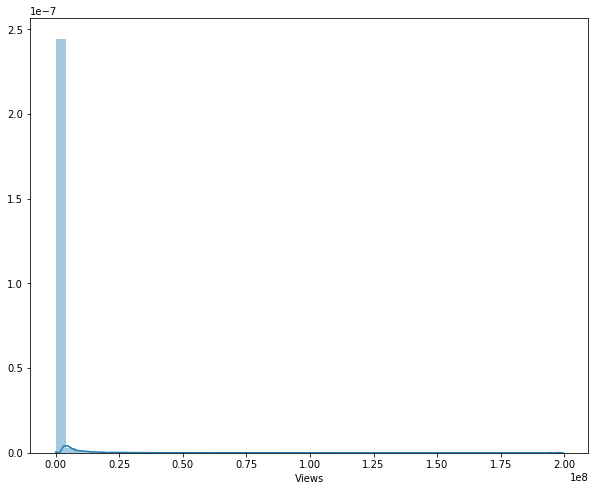

In [0]:
plt.figure(figsize=(10,8))
sns.distplot(train_updated['Views'])
# (non_zero)

In [0]:
mean_encode = train_updated.groupby('Genre')['Views'].mean()
train_updated.loc[:,'Gen_encode']=train_updated['Genre'].map(mean_encode)
test_updated.loc[:,'Gen_encode']=test_updated['Genre'].map(mean_encode)

train_updated.drop('Genre',axis=1,inplace=True)
test_updated.drop('Genre',axis=1,inplace=True)


In [0]:
mean_encode = train.groupby('Name')['Views'].mean()
train_updated.loc[:,'Name_encode']=train['Name'].map(mean_encode)
test_updated.loc[:,'Name_encode']=test['Name'].map(mean_encode)


,Unnamed: 0,Comments,Likes,Popularity,Followers,Gen_encode,day,weekday,month,year,hour,minute,train,Views,Name_encode
0,0,4,499,97.0,119563,266700.718641,30,4,3,2018,15,24,1,14017,29089.244662
1,1,17,49,17.0,2141,266700.718641,20,0,6,2016,5,58,1,1918,14068.125000
2,2,11,312,91.0,22248,266700.718641,8,4,5,2015,17,45,1,9668,16728.218750
3,3,2,2400,76.0,393655,609416.458326,8,3,6,2017,23,50,1,113036,208294.610000
4,4,81,3031,699.0,201030,266700.718641,17,5,9,2016,20,50,1,110024,107655.732394


In [0]:
test_updated.Name_encode.isna().sum()
# train_updated.Name_encode.isna().sum()

0

In [0]:
test_updated=test_updated.fillna(test_updated.mean())

In [0]:
y_train=train['Views']

In [0]:
print("Number of data points in train data", train_updated.shape)
print("Number of data points in test data", test_updated.shape)

Number of data points in train data (78458, 12)
Number of data points in test data (19615, 12)


In [0]:
train_updated['train']=1
test_updated['train']=0

In [0]:
combined=pd.concat([train_updated[['Name','train']],test_updated[['Name','train']]])

In [0]:
print(combined.shape)

(98073, 2)


**Mean target Encoding of the Name Column**

In [0]:
import category_encoders as ce
	
encoder = ce.BinaryEncoder(cols=['Name'])
df_binary = encoder.fit_transform(combined)


,Name_0,Name_1,Name_2,Name_3,Name_4,Name_5,Name_6,Name_7,Name_8,Name_9,Name_10,Name_11,train
2182,0,0,0,0,1,1,1,0,0,0,0,1,1


In [0]:
train_new = pd.concat([train_updated,df_binary[df_binary['train']==1]],axis=1)

In [0]:
train_new.head()

,Comments,Likes,Popularity,Followers,Gen_encode,day,weekday,month,year,hour,minute,Name_0,Name_1,Name_2,Name_3,Name_4,Name_5,Name_6,Name_7,Name_8,Name_9,Name_10,Name_11
0,4,499,97.0,119563,266700.718641,30,4,3,2018,15,24,0,0,0,0,0,0,0,0,0,0,0,1
1,17,49,17.0,2141,266700.718641,20,0,6,2016,5,58,0,0,0,0,0,0,0,0,0,0,1,0
2,11,312,91.0,22248,266700.718641,8,4,5,2015,17,45,0,0,0,0,0,0,0,0,0,0,1,1
3,2,2400,76.0,393655,609416.458326,8,3,6,2017,23,50,0,0,0,0,0,0,0,0,0,1,0,0
4,81,3031,699.0,201030,266700.718641,17,5,9,2016,20,50,0,0,0,0,0,0,0,0,0,1,0,1


In [0]:
test_new = pd.concat([test_updated,df_binary[df_binary['train']==0]],axis=1)
# test_new.head()

In [0]:
test_new.drop(columns="Name",inplace=True)
train_new.drop(columns="Name",inplace=True)
test_new.drop(columns="train",inplace=True)
train_new.drop(columns="train",inplace=True)

In [0]:
test_new.loc[:,'Gen_encode']=test_updated['Gen_encode']
test_new.drop(columns='Genre',inplace=True)
test_new.sample()

,Comments,Likes,Popularity,Followers,day,weekday,month,year,hour,minute,Name_0,Name_1,Name_2,Name_3,Name_4,Name_5,Name_6,Name_7,Name_8,Name_9,Name_10,Name_11,Gen_encode
17642,75,"4,411",706,460718,10,1,12,2013,16,10,0,0,0,1,1,0,0,0,1,0,1,0,266700.718641


In [0]:
test_updated=pd.read_csv('/content/drive/My Drive/dataset/ChartbustersParticipantsData/test_updated.csv')
train_updated=pd.read_csv('/content/drive/My Drive/dataset/ChartbustersParticipantsData/train_updated.csv')

In [0]:
train_updated[train_updated['Followers']>0.85e7].shape

(235, 14)

**Scatter plot distribution of the views column**

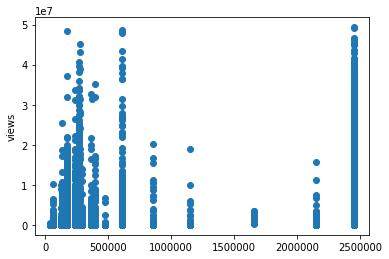

In [0]:
zz=train_updated[train_updated['Views']<0.5e8]
plt.scatter(zz['Gen_encode'],zz['Views'])
plt.ylabel('views')
plt.show()
# zz

In [0]:
def scatter_plot(x,y,df):
  plt.scatter(df['%s'%x],df['%s'%y])
  plt.ylabel('%s'%y)
  plt.show()

In [0]:
def sns_plots(x,y,df):
  sns.distplot(df['%s'%x],df['%s'%y])

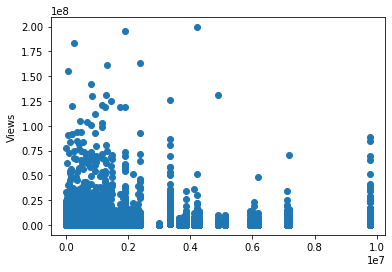

In [0]:
zz=train_updated
scatter_plot('Followers','Views',zz)

In [0]:
print(train_new.shape)
print(test_new.shape)
train_new.sample()


(78458, 24)
(19615, 24)


,Unnamed: 0,Comments,Likes,Popularity,Followers,Gen_encode,day,weekday,month,year,hour,minute,Name_0,Name_1,Name_2,Name_3,Name_4,Name_5,Name_6,Name_7,Name_8,Name_9,Name_10,Name_11
29448,29448,46,1177,203.0,147595,173650.330969,15,4,7,2016,13,33,0,0,0,1,0,1,0,0,1,0,0,1


In [0]:
train_new=pd.read_csv('/content/drive/My Drive/dataset/ChartbustersParticipantsData/train_new.csv',index_col=False)
test_new=pd.read_csv('/content/drive/My Drive/dataset/ChartbustersParticipantsData/test_new.csv',index_col=False)

In [0]:
# train_new.drop(columns='Unnamed: 0',inplace=True)
test_new.drop(columns='Unnamed: 0.1',inplace=True)

In [0]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train_new[list(train_new.columns)] = scaler.fit_transform(train_new[list(train_new.columns)])
# test_new[list(test_new.columns)] = scaler.fit_transform(test_new[list(test_new.columns)])

**After trying out different Scalar Robust Scalar turned out to be the best so I'm using robust scalar.**
1. It works well in this dataset as it has data which has outliers, so in this case robust scaler performs best 

In [0]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_new[list(train_new.columns)] = scaler.fit_transform(train_new[list(train_new.columns)])
test_new[list(test_new.columns)] = scaler.fit_transform(test_new[list(test_new.columns)])

In [0]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_new[list(train_new.columns)] = scaler.fit_transform(train_new[list(train_new.columns)])
# test_new[list(test_new.columns)] = scaler.fit_transform(test_new[list(test_new.columns)])

In [0]:
train_new = train_updated.copy()
test_new = test_updated.copy()

In [0]:
# train_new.drop(columns=['train','Views'],inplace=True)
# test_new.drop(columns='train',inplace=True)
train_new.head()

,Comments,Likes,Popularity,Followers,Gen_encode,day,weekday,month,year,hour,minute,Name_encode
0,-0.133333,-0.060796,0.046078,0.084800,0.000000,0.933333,0.333333,-0.571429,0.333333,0.090909,0.000000,-0.154684
1,0.083333,-0.226603,-0.178011,-0.227530,0.000000,0.266667,-1.000000,-0.142857,-0.333333,-0.818182,0.944444,-0.201463
2,-0.016667,-0.129698,0.029272,-0.174047,0.000000,-0.533333,0.333333,-0.285714,-0.666667,0.272727,0.583333,-0.193179
3,-0.166667,0.639646,-0.012745,0.813855,1.831112,-0.533333,0.000000,-0.142857,0.000000,0.818182,0.722222,0.403395
4,1.150000,0.872144,1.732353,0.301494,0.000000,0.066667,0.666667,0.285714,-0.333333,0.545455,0.722222,0.089987


**Model Initialization and training**

In [0]:
# custom function to run light gbm model
import lightgbm as lgb
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'regression',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'rmse'}

In [0]:
# gridParams = {
#     'learning_rate': [0.005],
#     'n_estimators': [40],
#     'num_leaves': [6,8,12,16],
#     'boosting_type' : ['gbdt'],
#     'objective' : ['regression'],
#     'random_state' : [501], # Updated from 'seed'
#     'colsample_bytree' : [0.65, 0.66],
#     'subsample' : [0.7,0.75],
#     'reg_alpha' : [1,1.2],
#     'reg_lambda' : [1,1.2,1.4],
#     }

# mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
#           objective = 'regression',
#           n_jobs = 3, # Updated from 'nthread'
#           silent = True,
#           max_depth = params['max_depth'],
#           max_bin = params['max_bin'],
#           subsample_for_bin = params['subsample_for_bin'],
#           subsample = params['subsample'],
#           subsample_freq = params['subsample_freq'],
#           min_split_gain = params['min_split_gain'],
#           min_child_weight = params['min_child_weight'],
#           min_child_samples = params['min_child_samples'],
#           scale_pos_weight = params['scale_pos_weight'])


In [0]:
# from sklearn.model_selection import GridSearchCV

# grid = GridSearchCV(mdl, gridParams,
#                     verbose=0,
#                     cv=4,
#                     n_jobs=2)
# # Run the grid
# grid.fit(train_new, y_train)

In [0]:
# LGBM_train = lgb.Dataset(train_X, label=train_Y)


In [0]:
y_train=train['Views']

**Dataset split into train and validation set**

In [0]:
train_X = train_new.iloc[0:60000].copy()
train_Y = y_train.iloc[0:60000].copy()

val_X= train_new.loc[60000:].copy()
val_Y = y_train.loc[60000:].copy()

**Finding the best number of iteration to run**

In [0]:
LGBM_train = lgb.Dataset(train_new, label=y_train,free_raw_data=False)
LGBM_model = lgb.train(params, LGBM_train, 3000, valid_sets=[LGBM_valid], early_stopping_rounds=500, verbose_eval=300)

Training until validation scores don't improve for 500 rounds.
[300]	valid_0's rmse: 399587
[600]	valid_0's rmse: 244499
[900]	valid_0's rmse: 178590
[1200]	valid_0's rmse: 142692
[1500]	valid_0's rmse: 117939
[1800]	valid_0's rmse: 101543
[2100]	valid_0's rmse: 90152.1
[2400]	valid_0's rmse: 81320.2
[2700]	valid_0's rmse: 74723.2
[3000]	valid_0's rmse: 69104.7
Did not meet early stopping. Best iteration is:
[3000]	valid_0's rmse: 69104.7


**Predicting on the test set**

In [0]:
predicted_test = LGBM_model.predict(test_new, num_iteration=LGBM_model.best_iteration)

XGB Modeling


#### model1

In [0]:
params=
{
learning_rate =0.01,
n_estimators=5000,
max_depth=4,
min_child_weight=6,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
reg_alpha=0.005,
nthread=4,
scale_pos_weight=1
}

In [0]:
  #  13.9Lakh
xgb1 = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 nthread=4,
 scale_pos_weight=1,
 eval_metric='rmse',
 seed=27)

# tr_data = xgb.DMatrix(train_new,y_train)
# watchlist = [(va_data, 'valid')]

model_xgb = xgb1.fit(train_new,y_train)


[15:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
# xgb1.get_params()

In [0]:
# test_new.columns=train_new.columns
# test_new.sample()

In [0]:

# dtest = xgb.DMatrix(test_new)
xgb_pred_y = model_xgb.predict(test_new)
predicted_test=xgb_pred_y

**Creating the submission file**

In [0]:
# rms = sqrt(mean_squared_error(y_actual, y_predicted))
sub= pd.read_excel('/content/drive/My Drive/dataset/ChartbustersParticipantsData/Sample_Submission.xlsx')


In [0]:
submission=pd.concat([sub['Unique_ID'],pd.Series(predicted_test)],axis=1)

In [0]:
submission.columns=['Unique_ID','Views']

In [0]:
submission['Views']=submission['Views'].round()
# submission.to_excel('/content/drive/My Drive/dataset/ChartbustersParticipantsData/sub11.xlsx',index=False)
# submission.head()

In [0]:
submission.to_excel('E:\sub1234.xlsx',index=False)